Randomized SVD. Draw $X \in \mathbb{R}^{m \times m}$ and $Y \in \mathbb{R}^{n \times }$ with $m \geq n$ uniformly at random
from the space of orthonormal matrices with $m = 1000$ and $n = 100000$. That is, X and Y
uniformly at random from $X^T X = I$ and $Y^TY = I$ e.g. in matlab $X=orth(randn(m,m))$
and $Y=orth(randn(n,m))$. Also set the diagonal matrix $D \in R^{m \times m}$ with diagonal entries

$$
D_{ii} = \begin{cases} r − i + 1 & \text{if } i \leq r\\
4 * 10^{−3} & \text{if } i > r
\end{cases}
$$

with $r = 10$. Set $A \in R^{m \times n}$ equal to $A = XDY^T$ . Use the randomized SVD of Drineas
et al. to calculate the r = 10 top eigenvectors of A. Let $A = U\Sigma V^T$ with $U \in R^{m \times m}$,
$V \in R^{n\times n}$ , and $\Sigma \in \mathbb{R}^{m \times n}$ be the singular value decomposition of A. 
Also let $U_r$ and $V_r$ be the singular vectors corresponding to the top $r$ singular values (if the singular values are
ordered in decreasing order this corresponds to the first $r$ columns of $U$ and $V$ ).


(i) How large does $c$ (number of drawn columns/rows) has to be so we can calculate the eigenvectors with relative errors of $\epsilon = 0.01, 0.05, 0.1$ That is,

$$\frac{||\hat{U}_r \hat{U}_r^T − U_rU_r^T||}{||U_rU_r^T||} \leq \epsilon$$

and 

$$\frac{||\hat{V}_r \hat{V}_r^T − V_rV_r^T||}{||V_rV_r^T||} \leq \epsilon$$

Report this number based on the average of 10 random draws from the columns of A.
That is for the matrix A draw $c$ columns 10 independent times. Compare the average
run time (over the 10 random draws) with that of using an SVD on A. Would you use
the randomized SVD algorithm?

Clarification: In the algorithm of Drineas et. al. to estimate $U_r$ you draw columns at
random and to estimate $V_r$ you draw rows at random.


Hint: Note that $||U_r U_r^T|| = ||V_r V_r^T|| = 1$. Also note that to calculate $||\hat{U}_r \hat{U}_r^T - \hat{U}_r \hat{U}_r^T||$
and $||\hat{V}_r \hat{V}_r^T - V_r V_r||$ you don’t need to build the matrices explicitly (in which case
you probably get an out of memory error). You can calculate the spectral norm of
$\hat{U}_r \hat{U}_r^T - U_r U_r^T$ via the power method by calculating matrix-vector products of the form
$(\hat{U}_r \hat{U}_r^T - U_r U_r^T) z$ which can be carried out efficiently. However, note that to calculate
the spectrum of the matrix $\hat{U}_r \hat{U}_r^T - U_r U_r^T$ you should probably apply the power method
using $(\hat{U}_r \hat{U}_r^T - U_r U_r^T)^2$ as the power method directly on $\hat{U}_r \hat{U}_r^T - U_r U_r^T$ will fail. Do
you know why?


In [8]:
%pylab inline
from scipy.linalg import svd
from numpy.linalg import norm
from scipy.sparse.linalg import svds, eigs
from sklearn.decomposition import TruncatedSVD
from sklearn.utils.extmath import randomized_svd
import time
from collections import defaultdict

m = 1000
n = 100000

epsilon = [0.01, 0.05, 0.1]
# Ur
np.random.seed(42)

import pandas as pd
import matplotlib as mpl

from matplotlib.ticker import ScalarFormatter, AutoMinorLocator
mpl.rcParams['grid.color'] = 'k'
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['grid.linewidth'] = 0.5
mpl.rcParams['font.size'] = 32
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['figure.figsize'] = (7.2,4.45)
mpl.rcParams['axes.titlesize'] = 32
mpl.rcParams['axes.labelsize'] = 32
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = 6
mpl.rcParams['legend.fontsize'] = 13
mpl.rcParams['mathtext.fontset'] = 'stix'      
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['lines.linewidth'] = 3.5
mpl.rcParams['xtick.labelsize'] = 32
mpl.rcParams['ytick.labelsize'] = 32
mpl.rcParams['legend.fontsize'] = 32
             
def setup_axis(ax):
    ax.set_xlabel('')
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.major.formatter._useMathText = True
    ax.yaxis.set_minor_locator(  AutoMinorLocator(5))
    ax.xaxis.set_minor_locator(  AutoMinorLocator(5))
    ax.tick_params(direction='out', length=12, 
                   width=2, 
                   grid_alpha=0.5)
    ax.tick_params(direction='out', which='minor', length=6, 
                   width=1, 
                   grid_alpha=0.5)
    ax.grid(True)

def get_Ur_hat(A, c, r):
    B = []
    col_probabilities = np.power(norm(A, 2, 0),2)/norm(A, 'fro')**2
    col_choices = range(0, A.shape[1])                
    cols_to_sample = np.random.choice(col_choices, c, p=col_probabilities)
    B = A[:, cols_to_sample]
    #Ur_hat_complete, U_singular_values_hat, Ur_VrT_hat_complete= svd(B)
    Ur_hat_complete, U_singular_values_hat, Ur_VrT_hat_complete = randomized_svd(B, 
                                                                                 n_components=r,
                                                                                 n_iter=5,
                                                                                 random_state=None)
    Ur_hat = Ur_hat_complete
    #Ur_hat = Ur_hat_complete[:, :r]
    
    return Ur_hat

# Vr
def get_Vr_hat(A, c, r):
    B = []
    row_probabilities = np.power(norm(A, 2, 1),2)/norm(A, 'fro')**2
    row_choices = range(0, A.shape[0])                
    rows_to_sample = np.random.choice(row_choices, c, p=row_probabilities)
    B = A[rows_to_sample, :]
    #Vr_hat_complete, Vr_singular_values_hat, Vr_VrT_hat_complete = svd(B)
    Vr_hat_complete, Vr_singular_values_hat, Vr_VrT_hat_complete = randomized_svd(B, 
                                  n_components=r,
                                  n_iter=5,
                                  random_state=None)
    Vr_hat = Vr_VrT_hat_complete
    return Vr_hat


def power_iteration(A, eps=1e-3, n_steps=1000):
    z_k = np.random.rand(A.shape[1])

    for _ in range(n_steps):
        # calculate the matrix-by-vector product Ab
        z_k1 = np.dot(A, z_k)

        # calculate the norm
        z_k1_norm = np.linalg.norm(z_k1)

        # re normalize the vector
        z_k = z_k1 / z_k1_norm
        z_diff = np.linalg.norm(z_k - z_k1)
        if z_diff<=eps:
            print('converged')
            return z_k
    return z_k
   
def power_method(Xr , eps=1e-6, n_steps=1000):
    """returns singular value of UrUr^T"""
    z_k = np.random.rand(Xr.T.shape[1])
    z_k = z_k[:, np.newaxis]
    for _ in range(n_steps):
        # calculate the matrix-by-vector product Ab
        Xr_T_z_k1 = np.dot(Xr.T, z_k)
        Xr_Xr_T_z_k1 = np.dot(Xr, Xr_T_z_k1)

        # calculate the norm
        Xr_Xr_T_z_k1_norm = np.linalg.norm(Xr_Xr_T_z_k1)

        # re normalize the vector
        z_k = Xr_Xr_T_z_k1 / Xr_Xr_T_z_k1_norm
        z_diff = np.linalg.norm(z_k - Xr_Xr_T_z_k1)
    
    return np.abs(np.dot(z_k.T, np.dot(Xr, np.dot(Xr.T, z_k)))[0][0]), z_k

def power_method_ur(Xr_hat, Xr , eps=1e-6, n_steps=1000):
    """REturns  singular value  of Ur_hatUr_hat^T-UrUr^T"""
    z_k = np.random.rand(Xr.T.shape[1])
    z_k = z_k[:, np.newaxis]
    for _ in range(n_steps):
        # calculate the matrix-by-vector product Ab
        z_k1 = np.dot(Xr.T, z_k)
        z_k1 = np.dot(Xr, z_k1)
        
        z_k1_hat = np.dot(Xr_hat.T, z_k)
        z_k1_hat = np.dot(Xr_hat, z_k1_hat)
        
        z_k1_diff = z_k1_hat - z_k1
        # calculate the norm
        z_k1_norm = np.linalg.norm(z_k1_diff)

        # re normalize the vector
        z_k = z_k1_diff / z_k1_norm
        z_succ_diff = np.linalg.norm(z_k - z_k1_diff)
    XrXrTz = np.dot(Xr, np.dot(Xr.T, z_k))
    XrXrTz_hat = np.dot(Xr_hat, np.dot(Xr_hat.T, z_k))
    return np.abs(np.dot(z_k.T, XrXrTz_hat-XrXrTz)[0][0]), z_k

Populating the interactive namespace from numpy and matplotlib


/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['svd']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [6]:
def get_A(m, n, r):
    XF = np.random.random(size=(m, m))
    X, _ = np.linalg.qr(XF)

    YF = np.random.random(size=(n, m))
    Y, _ = np.linalg.qr(YF)

    x = [r-i+1 for i in range(0, r)] + [4*0.001 for i in range(r, m)]
    x = np.array(x)


    D = np.diag(x)

    A = np.matmul(np.matmul(X,D), Y.T)
    return A

In [36]:
optimized_values = defaultdict(dict)
r_vs_time = {}
r_vs_time = defaultdict(dict)

for r in [2, 5, 15, 20]:
    start = time.time()
    A = get_A(m, n, r)
    Ur, Sr, VrT = svds(A, k=r)
    end = time.time()

    svds_time = end - start
    r_vs_time[r]['svd'] = svds_time
    for eps in epsilon:
        for c in range(r, 50):
            error_u = 0
            error_v = 0
            start_time = time.time()
            for i in range(0, 10):
                Ur_hat = get_Ur_hat(A, c, r)
                Vr_hat = get_Vr_hat(A, c, r)

                U_error = power_method_ur(Ur_hat, Ur)[0]
                U_error = U_error/power_method(Ur)[0]

                V_error = power_method_ur(Vr_hat, VrT)[0]
                V_error = V_error/power_method(VrT)[0]
                error_u += U_error
                error_v += V_error
            end_time = time.time()
            total_time_10_iter = end_time - start_time
            if (error_u/10 <= eps) and (error_v/10 <= eps):
                r_vs_time[r][eps] = total_time_10_iter
                print('r={} | eps = {} | c = {} | error_U = {} | error_V = {}'.format(r, eps, c, error_u/10, error_v/10))
                optimized_values[r][eps] = c
                break
        
        

/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/ipykernel/__main__.py:102: RuntimeWarning: invalid value encountered in true_divide


r=2 | eps = 0.01 | c = 5 | error_U = 0.0022013881125119567 | error_V = 6.81539542265001e-16
r=2 | eps = 0.05 | c = 2 | error_U = 0.026833748419600168 | error_V = 4.557430599291581e-16
r=2 | eps = 0.1 | c = 2 | error_U = 0.0645485376882004 | error_V = 8.25417939703698e-16
r=5 | eps = 0.01 | c = 7 | error_U = 0.005432343146224663 | error_V = 1.6533463554178675e-15
r=5 | eps = 0.05 | c = 6 | error_U = 0.026876439092474884 | error_V = 1.2926083340881245e-15
r=5 | eps = 0.1 | c = 5 | error_U = 0.06843723637922254 | error_V = 8.001236683453326e-16
r=15 | eps = 0.01 | c = 21 | error_U = 0.009735356603238298 | error_V = 2.5848269801038498e-14
r=15 | eps = 0.05 | c = 16 | error_U = 0.018364711345005974 | error_V = 2.6344369714404263e-14
r=15 | eps = 0.1 | c = 16 | error_U = 0.03300874270510291 | error_V = 2.5685755004182717e-14
r=20 | eps = 0.01 | c = 33 | error_U = 0.007107170060425591 | error_V = 9.620587741906648e-15
r=20 | eps = 0.05 | c = 22 | error_U = 0.02736972556159113 | error_V = 1.06

In [51]:
df = pd.DataFrame(r_vs_time)
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &         2  &         5  &          15 &          20 \\
\midrule
0.05 &  10.616179 &  39.524281 &   99.357028 &  130.747681 \\
0.1  &  10.292353 &  17.767485 &   98.596256 &   18.125567 \\
svd  &   8.875531 &   8.925866 &    9.523213 &   10.056283 \\
0.01 &  24.633166 &  40.737450 &  107.400733 &  143.249402 \\
\bottomrule
\end{tabular}



/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


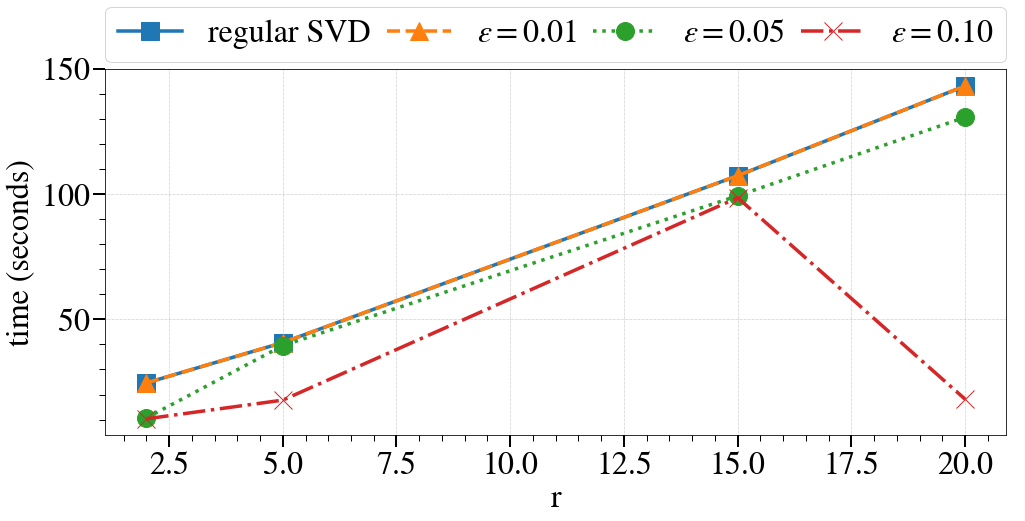

In [47]:
fig, ax = plt.subplots(figsize=(15,8))
ax.plot(df.columns, df.loc[0.01, :], marker='s', linestyle='-', markersize=18, label='regular SVD')
ax.plot(df.columns, df.loc[0.01, :], marker='^', linestyle='--', markersize=18, label='$\epsilon=0.01$')
ax.plot(df.columns, df.loc[0.05, :], marker='o', linestyle=':', markersize=18, label='$\epsilon=0.05$')
ax.plot(df.columns, df.loc[0.10, :], marker='x', linestyle='-.', markersize=18, label='$\epsilon=0.10$')
setup_axis(ax)
ax.set_xlabel('r')
ax.set_ylabel('time (seconds)')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=4, mode="expand", borderaxespad=0.)
fig.tight_layout()
fig.savefig('time_ms.pdf')

In [52]:
df = pd.DataFrame(optimized_values)
print(df.to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  2  &  5  &  15 &  20 \\
\midrule
0.01 &   5 &   7 &  21 &  33 \\
0.05 &   2 &   6 &  16 &  22 \\
0.10 &   2 &   5 &  16 &  20 \\
\bottomrule
\end{tabular}



/home/cmb-panasas2/skchoudh/software_frozen/anaconda27/envs/riboraptor/lib/python3.5/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


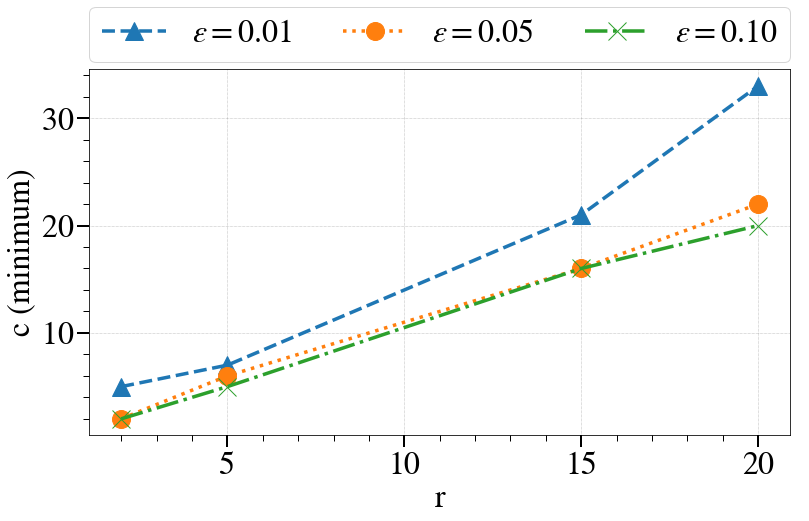

In [49]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df.columns, df.loc[0.01, :], marker='^', linestyle='--', markersize=18, label='$\epsilon=0.01$')
ax.plot(df.columns, df.loc[0.05, :], marker='o', linestyle=':', markersize=18, label='$\epsilon=0.05$')
ax.plot(df.columns, df.loc[0.10, :], marker='x', linestyle='-.', markersize=18, label='$\epsilon=0.10$')
setup_axis(ax)
ax.set_xlabel('r')
ax.set_ylabel('c (minimum)')
ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
              ncol=3, mode="expand", borderaxespad=0.)
fig.tight_layout()
fig.savefig('r_vs_c.pdf')